# 양서강(개구리목, 도롱뇽목, 무족영원목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [3]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
#[220811_1321]CREATED 9개의 종을 쿼리로 날리고 부정확한 검색 결과를 제거하기 위해 CO1 여부와 종 명칭 일치 여부를 확인하여 정확한 FASTA파일만을 수집하도록 함 -> 기존 144개보다 3배 많은 418개 데이터 확보
#[220818_2215]CREATED 양서강의 개구리, 도롱뇽, 무족영원목에 속하는 9종 선정
species = ['Lithobates catesbeianus', 'Bufo gargarizans', 'Dryophytes japonicus', 
           'Hynobius leechii', 'Dicamptodon ensatus', 'Siren intermedia', 
           'Ichthyophis bannanicus', 'Boulengerula changamwensis', 'Caecilia tentaculata']
count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

## creating EF525863.1.fasta...
## creating EF525862.1.fasta...
## creating EF525861.1.fasta...
## creating EF525860.1.fasta...
## creating EF525859.1.fasta...
## creating EF525858.1.fasta...
## creating EF525857.1.fasta...
## creating EF525856.1.fasta...
## creating EF525855.1.fasta...
## creating EF525854.1.fasta...
## creating EF525853.1.fasta...
## creating EF525852.1.fasta...
## creating EF525851.1.fasta...
## creating EF525848.1.fasta...
## creating MH034267.1.fasta...
## creating MH034266.1.fasta...
## creating KY587197.1.fasta...
## creating KT388393.1.fasta...
## creating KT388392.1.fasta...
## creating KT388391.1.fasta...
## creating JQ798860.1.fasta...
## creating JQ798859.1.fasta...
## creating JQ798858.1.fasta...
## creating JQ844537.1.fasta...
## creating JQ844536.1.fasta...
## creating JQ844535.1.fasta...
## creating AF314016.1.fasta...
## creating KF665641.1.fasta...
## creating KF665586.1.fasta...
## creating JQ798832.1.fasta...
## creating JQ798831.1.fasta...
## creat

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [2]:
def setGC(filename, index):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    l = []
    for record in file:
        l.append(len(record.seq))
    k_gc = min(l)
    k_gc += index
    #print(k_gc)
    return k_gc
    #[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

def creMaxGCDf(filename, k_gc):
    import pandas as pd
    import numpy as np
    
    gc_df = pd.DataFrame()
    gc_df['start index'] = 0
    gc_df['gc-contents'] = 0

    file = SeqIO.parse(filename, 'fasta')

    for i, record in enumerate(file):
        index = 0
        gc_rates = []
        while(index + k_gc <= len(record.seq)):
            mer = record.seq[index:index + k_gc]
            gc_rates.append(GC(mer))
            index += 1
        if(index == 0):
            gc_rates.append(GC(record.seq))
        gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
        gc_df.loc[i, 'gc-contents'] = max(gc_rates)
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장
    return gc_df

In [3]:
sum(l) / len(l)

653.6186440677966

### 기존 데이터 슬라이싱 후 3-mer 적용

In [22]:
def creDf(filename, gc_df, k_gc):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    k = 3
    dict = {}
    df = pd.DataFrame()

    #[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
    base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
    'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

    #[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
    def init(datatype):
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
        #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
        datatype['GC-contents'] = 0
        datatype['target'] = 0
        
    init(df)

    for i, record in enumerate(file):
        init(dict)
        record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
        #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
        dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
        #[220805_1025]CREATED 최대 GC 값 저장
        dict['target'] = getGenbank(record.id).organism
        
        index = 0
        
        if(len(record.seq) >= k):
            while(index + k <= len(record.seq)):
                mer = record.seq[index:index + k]
                for p in range(k):
                    mer = mer.replace(mer[p], base_dict.get(mer[p]))
                dict[mer] += 1
                index += 1
        df.loc[i] = dict
    return df

In [23]:
def calSilhouette(df):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import numpy as np

    df['sil_sam'] = silhouette_samples(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('target')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    #print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    #print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    #print('---------------')
    return sil_tot / score_k

In [52]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Lithobates catesbeianus', 'Hynobius leechii', 'Siren intermedia',
       'Dryophytes japonicus', 'Ichthyophis bannanicus',
       'Bufo gargarizans', 'Caecilia tentaculata', 'Dicamptodon ensatus',
       'Boulengerula changamwensis'], dtype=object)

In [97]:
""" # row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)
 """
pd.reset_option('^display.', silent=True)

df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,13,9,9,5,6,9,9,2,6,3,...,6,4,5,11,11,4,11,9,47.105263,Lithobates catesbeianus
1,22,11,8,10,7,7,7,3,5,4,...,6,2,6,8,15,4,10,18,40.263158,Hynobius leechii
2,14,11,8,10,10,7,8,5,6,1,...,4,1,4,15,12,6,9,13,40.526316,Siren intermedia
3,6,4,11,13,3,5,14,10,12,3,...,6,7,13,18,18,7,16,17,49.736842,Lithobates catesbeianus
4,6,4,11,13,3,5,14,10,12,3,...,6,7,13,18,18,7,16,17,49.473684,Lithobates catesbeianus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6,4,11,13,3,5,14,10,12,3,...,7,7,13,18,16,7,16,17,50.000000,Lithobates catesbeianus
114,5,1,9,8,1,7,6,2,8,1,...,12,2,6,15,8,6,13,12,46.578947,Dryophytes japonicus
115,6,3,10,13,4,7,12,7,13,3,...,7,6,14,15,15,7,15,20,48.421053,Lithobates catesbeianus
116,6,3,10,13,4,7,12,7,13,3,...,7,6,14,15,15,7,15,20,48.421053,Lithobates catesbeianus


In [98]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[7 5 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 6 6 5 1 1 1 5 5 5 1 1 1 7 7 7 4 5 5 1 1 1 4 4 4 4 7 7 7 4 4 4 4 4 4 4 4 4
 4 1 1 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 2 2 3 3 3 8 3 3 0 4 4 4 4 4 4 4 4 4 4
 4 4 7 4 7 7 8]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,13,9,9,5,6,9,9,2,6,3,...,6,4,5,11,11,4,11,9,47.105263,7
1,22,11,8,10,7,7,7,3,5,4,...,6,2,6,8,15,4,10,18,40.263158,5
2,14,11,8,10,10,7,8,5,6,1,...,4,1,4,15,12,6,9,13,40.526316,8
3,6,4,11,13,3,5,14,10,12,3,...,6,7,13,18,18,7,16,17,49.736842,7
4,6,4,11,13,3,5,14,10,12,3,...,6,7,13,18,18,7,16,17,49.473684,7


In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [100]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,13,9,9,5,6,9,9,2,6,3,...,6,4,5,11,11,4,11,9,0.634615,7
1,22,11,8,10,7,7,7,3,5,4,...,6,2,6,8,15,4,10,18,0.134615,5
2,14,11,8,10,10,7,8,5,6,1,...,4,1,4,15,12,6,9,13,0.153846,8
3,6,4,11,13,3,5,14,10,12,3,...,6,7,13,18,18,7,16,17,0.826923,7
4,6,4,11,13,3,5,14,10,12,3,...,6,7,13,18,18,7,16,17,0.807692,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6,4,11,13,3,5,14,10,12,3,...,7,7,13,18,16,7,16,17,0.846154,7
114,5,1,9,8,1,7,6,2,8,1,...,12,2,6,15,8,6,13,12,0.596154,4
115,6,3,10,13,4,7,12,7,13,3,...,7,6,14,15,15,7,15,20,0.730769,7
116,6,3,10,13,4,7,12,7,13,3,...,7,6,14,15,15,7,15,20,0.730769,7


## SVM 모델 생성

In [101]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df.loc[:, 'AAA':'GC-contents']
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

/Users/kimjoonsu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 1, 'gamma': 1}
0.9146198830409358
오차 행렬
[[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 5 0 0 0]
 [0 0 0 0 6 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 7]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


## KMeans 모델의 최적 K값 구하기

### Elbow Method

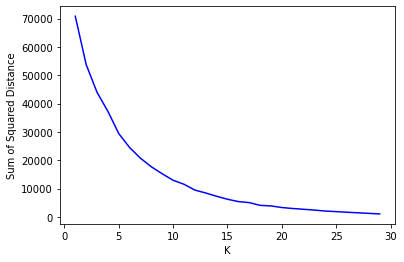

In [102]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 5000)
    km.fit(df.loc[:,'AAA':'GC-contents'])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

### Silhouette Method

In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df.loc[:,'AAA':'GC-contents'])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.loc[:,'AAA':'GC-contents'], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,'AAA':'GC-contents'], df['cluster'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220811_1518]NOTED k = 10일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.264
군집 별 실루엣 계수 평균: 
cluster
0    0.180153
1    0.422537
Name: sil_sam, dtype: float64
score: 0.121
---------------
전체 실루엣 계수 평균: 0.292
군집 별 실루엣 계수 평균: 
cluster
0    0.391897
1    0.347152
2    0.198042
Name: sil_sam, dtype: float64
score: 0.083
---------------
전체 실루엣 계수 평균: 0.355
군집 별 실루엣 계수 평균: 
cluster
0    0.219741
1    0.332610
2    0.570645
3    0.324762
Name: sil_sam, dtype: float64
score: 0.101
---------------
전체 실루엣 계수 평균: 0.424
군집 별 실루엣 계수 평균: 
cluster
0    0.322702
1    0.567208
2    0.283047
3    0.552289
4    0.422159
Name: sil_sam, dtype: float64
score: 0.103
---------------
전체 실루엣 계수 평균: 0.469
군집 별 실루엣 계수 평균: 
cluster
0    0.422107
1    0.282312
2    0.549992
3    0.546909
4    0.269613
5    0.773402
Name: sil_sam, dtype: float64
score: 0.149
---------------
전체 실루엣 계수 평균: 0.497
군집 별 실루엣 계수 평균: 
cluster
0    0.773402
1    0.590710
2    0.354181
3    0.540805
4    0.535833
5    0.063474
6    0.372199
Name: sil_sam, dtype: float64
score: 0.165
--------------

## k_gc 변화에 따른 원본 분포 양상 그래프 자동 생성

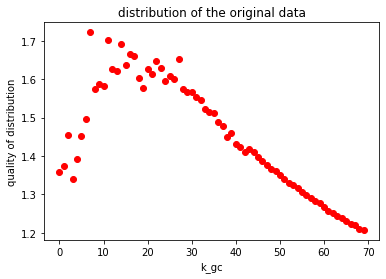

In [4]:
def setGC(filename, index):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    l = []
    for record in file:
        l.append(len(record.seq))
    k_gc = min(l)
    k_gc += index
    #print(k_gc)
    return k_gc
    #[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

def creMaxGCDf(filename, k_gc):
    import pandas as pd
    import numpy as np
    
    gc_df = pd.DataFrame()
    gc_df['start index'] = 0
    gc_df['gc-contents'] = 0

    file = SeqIO.parse(filename, 'fasta')

    for i, record in enumerate(file):
        index = 0
        gc_rates = []
        while(index + k_gc <= len(record.seq)):
            mer = record.seq[index:index + k_gc]
            gc_rates.append(GC(mer))
            index += 1
        if(index == 0):
            gc_rates.append(GC(record.seq))
        gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
        gc_df.loc[i, 'gc-contents'] = max(gc_rates)
        #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장
    return gc_df

def creDf(filename, gc_df, k_gc):
    import pandas as pd
    import numpy as np

    file = SeqIO.parse(filename, 'fasta')

    k = 3
    dict = {}
    df = pd.DataFrame()

    #[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
    base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
    'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

    #[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
    def init(datatype):
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
        #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
        datatype['GC-contents'] = 0
        datatype['target'] = 0
        
    init(df)

    for i, record in enumerate(file):
        init(dict)
        record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
        #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
        dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
        #[220805_1025]CREATED 최대 GC 값 저장
        dict['target'] = getGenbank(record.id).organism
        
        index = 0
        
        if(len(record.seq) >= k):
            while(index + k <= len(record.seq)):
                mer = record.seq[index:index + k]
                for p in range(k):
                    mer = mer.replace(mer[p], base_dict.get(mer[p]))
                dict[mer] += 1
                index += 1
        df.loc[i] = dict
    return df

def calSilhouette(df):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import numpy as np

    df['sil_sam'] = silhouette_samples(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('target')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    #print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    #print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    #print('---------------')
    return sil_tot / score_k



import matplotlib.pyplot as plt
import numpy as np

index = 0
filename = 'all_amphibia_coi.fasta'

sil_ratios = []

for i in range(0, 700, 10):
    k_gc = setGC(filename, i)
    gc_df = creMaxGCDf(filename, k_gc)
    df = creDf(filename, gc_df, k_gc)
    sil_ratios.append(calSilhouette(df))

plt.plot(np.arange(0, 70), sil_ratios, 'ro')
plt.title('distribution of the original data')
plt.xlabel('k_gc')
plt.ylabel('quality of distribution')
plt.show()
plt.close()

## K-means 모델 생성

In [104]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 교차 검증

* 검증 데이터셋 생성x(학습 데이터량의 변화에 따른 모델의 정확도 변화 분석에 용이)

In [105]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 1
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_test = data.iloc[start_index:start_index + len(df.index) // cv]
    y_test = label[start_index:start_index + len(df.index) // cv]
    kmeans = KMeans(n_clusters = len(y_test.unique()), max_iter = 1000)
    kmeans.fit(X_test)
    accuracy.append(np.round(cal_accuracy(y_test, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))
#[220813_1117]NOTED 검증 데이터셋이 없고, 학습 데이터셋의 수는 cv값과 반비례하기 때문에, cv값이 증가함에 따라 정확도는 감소
#[220813_1117]NOTED 학습 데이터 수가 줄어듬에 따라 모델의 정확도 변화율을 분석하기에 용이

교차 검증별 정확도: [0.8506]
평균 검증 정확도: 0.8506


* 검증 데이터셋 생성

In [106]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 5
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_train, X_test = pd.concat([data.iloc[0:start_index], data.iloc[start_index + len(df.index) // cv:]]), data.iloc[start_index:start_index + len(df.index) // cv]
    y_train, y_test = pd.concat([label[0:start_index], label[start_index + len(df.index) // cv:]]), label[start_index:start_index + len(df.index) // cv] 
    #[220813_1108]CREATED X_test, y_test: 검증 데이터셋
    kmeans = KMeans(n_clusters = len(y_train.unique()), max_iter = 1000)
    kmeans.fit(X_train)
    accuracy.append(np.round(cal_accuracy(y_train, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    #[220813_1108]CREATED predict()를 통해 새로운 데이터셋에 대한 cluster 레이블을 출력하여 정답지인 y_test와 비교한다.
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))

교차 검증별 정확도: [0.834, 0.7786, 0.8267, 0.7778, 0.7606]
평균 검증 정확도: 0.7955


## 차원 축소 및 데이터 분포 확인

In [107]:
km = KMeans(n_clusters = 9, max_iter = 1000)
km.fit(df.loc[:,'AAA':'GC-contents'])
df['cluster'] = km.labels_

In [108]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster
0,13,9,9,5,6,9,9,2,6,3,...,4,5,11,11,4,11,9,0.634615,7,8
1,22,11,8,10,7,7,7,3,5,4,...,2,6,8,15,4,10,18,0.134615,5,8
2,14,11,8,10,10,7,8,5,6,1,...,1,4,15,12,6,9,13,0.153846,8,8
3,6,4,11,13,3,5,14,10,12,3,...,7,13,18,18,7,16,17,0.826923,7,4
4,6,4,11,13,3,5,14,10,12,3,...,7,13,18,18,7,16,17,0.807692,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6,4,11,13,3,5,14,10,12,3,...,7,13,18,16,7,16,17,0.846154,7,4
114,5,1,9,8,1,7,6,2,8,1,...,2,6,15,8,6,13,12,0.596154,4,8
115,6,3,10,13,4,7,12,7,13,3,...,6,14,15,15,7,15,20,0.730769,7,4
116,6,3,10,13,4,7,12,7,13,3,...,6,14,15,15,7,15,20,0.730769,7,4


In [109]:
df['cluster'].unique()

array([8, 4, 2, 7, 3, 5, 6, 0, 1], dtype=int32)

In [110]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_transformed = pca.fit_transform(df.loc[:,'AAA':'GC-contents'])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster,pca_x,pca_y
0,13,9,9,5,6,9,9,2,6,3,...,11,11,4,11,9,0.634615,7,8,21.982600,-10.916560
1,22,11,8,10,7,7,7,3,5,4,...,8,15,4,10,18,0.134615,5,8,15.468499,-14.293372
2,14,11,8,10,10,7,8,5,6,1,...,15,12,6,9,13,0.153846,8,8,16.302137,-13.197113
3,6,4,11,13,3,5,14,10,12,3,...,18,18,7,16,17,0.826923,7,4,11.004712,12.748978
4,6,4,11,13,3,5,14,10,12,3,...,18,18,7,16,17,0.807692,7,4,10.443569,12.198776


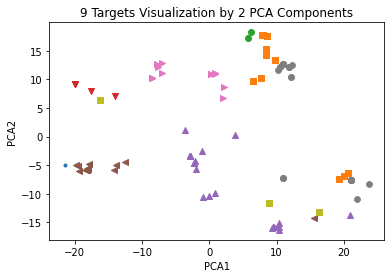

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

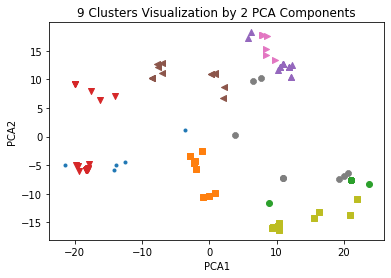

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)
    
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

In [113]:
print(cal_accuracy(df['target'], df['cluster']))

0.7665147396948162


In [114]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8
target,,,,,,,,,
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,6,5,0
2,0,0,0,0,2,0,0,0,0
3,0,0,0,5,0,0,0,0,0
4,1,19,0,0,0,0,0,1,8
5,3,0,0,22,0,0,0,0,1
6,0,0,0,0,0,14,0,0,0
7,0,0,9,0,14,0,0,3,1
8,0,0,1,1,0,0,0,0,1


In [121]:
km2 = KMeans(n_clusters = 17, max_iter = 1000)
km2.fit(df.loc[:,'AAA':'GC-contents'])
print(cal_accuracy(df['target'], km2.labels_))

0.7188956920757685
